# Binary classification with Adaline and logistic function and cross-entropy

Author: Theresa Ullmann

* implementation of the Adaline for the MNIST data
* the MNIST data consists of images with hand-written digits, we try to predict the correct digit
* only the digits 0 and 1 are considered (binary classification)
* logistic activation function, two different loss functions: quadratic and cross-entropy

In [24]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [25]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 8]
matplotlib.rc("savefig", dpi=200)

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

In [26]:
mnist_dest = "./MNIST/"

import mnist

data = mnist.MNIST(mnist_dest)



10000 test images
60000 training images


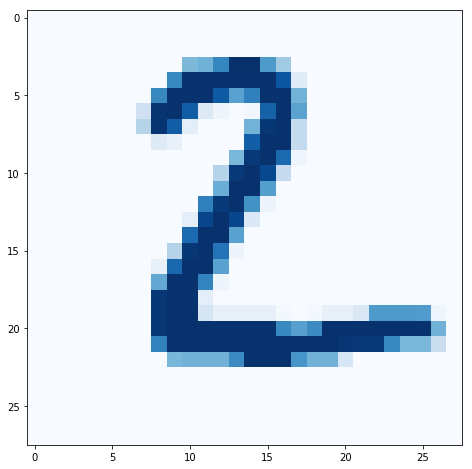

2


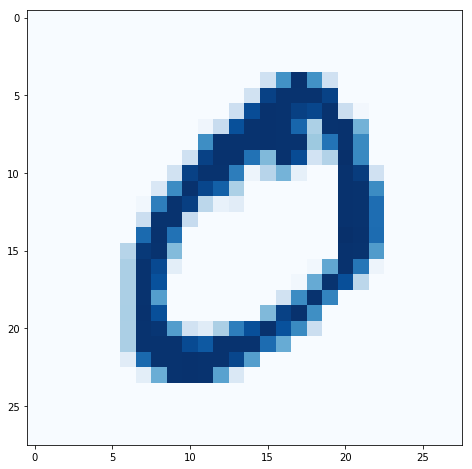

0


In [27]:
print('%d test images' % len(data.test_imgs))
print('%d training images' % len(data.train_imgs))


plt.imshow(data.test_imgs[1], cmap = 'Blues')
plt.show()
print(data.test_labels[1])

plt.imshow(data.train_imgs[1], cmap = 'Blues')
plt.show()
print(data.train_labels[1])


In [28]:
# each image can be represented as a 28x28 "pixel" matrix where every entry corresponds to the color of the pixel
print(data.test_imgs[1])
data.test_imgs[1].shape

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 116 125 171 255 255 150  93   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 169 253 253 253 253 253 253 218  30
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 169 253 253 253 213 142 176 253 253 122
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  52 250 253 210  32  12   0   6 206 253 140
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  77 251 210  25   0   0   0 122 248 253  65
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  31  18   0   0   0   0 209 25

(28, 28)

In [10]:
X_train = np.array([data.train_imgs[i].reshape(1, data.rows * data.cols)[0]/ 255.0
            for i in range(len(data.train_imgs))
             if data.train_labels[i] in (0,1)])

X_test = np.array([data.test_imgs[i].reshape(1, data.rows * data.cols)[0]/ 255.0
           for i in range(len(data.test_imgs))
             if data.test_labels[i] in (0,1)])

print(X_train)
print(X_train.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(12665, 784)


In [11]:
Y_train = np.array([data.train_labels[i] for i in range(len(data.train_imgs))
             if data.train_labels[i] in (0,1)])

Y_test = np.array([data.test_labels[i] for i in range(len(data.test_imgs))
             if data.test_labels[i] in (0,1)])

print(Y_train)
print(Y_train.shape)

[0 1 1 ... 1 0 1]
(12665,)


In [12]:
# Adaline for logistic activation, quadratic loss

class AdalineQuadrLoss:

    def __init__(self, num):
        '''
        initialize class for `num` input signals
        '''

        # weights of the Adaline, initialized to zero
        # note the '1 + ' as the first weight entry is the threshold
        self.w_ = 0.025*np.ones(1 + num)

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        # compute alpha(w*x)
        input = 1/(1+np.exp(-np.dot(X, self.w_[1:]) + self.w_[0]))

        return input

    def classify(self, X):
        '''
        classify the data by sending the activation input through a step function
        '''
        return np.where(self.activation_input(X) >= 0.5, 1, 0)
    
    def learn(self, X_train, Y_train, eta=0.01, epochs=1000):
        '''
        fit training data according to eta and n_iter
        and log the errors in errors_
        '''

        # we initialize two list, each for the misclassifications and the cost function
        self.train_errors_ = []
        self.train_loss_ = []

        # for all the epoch
        for _ in range(epochs):
            # classify the traning features
            Z = self.classify(X_train)
            # count the misqualifications for the logging
            err = 0
            for z, y in zip(Z, Y_train):
                err += int(z != y)
            # ans save them in the list for later use
            self.train_errors_.append(err)
            
            # compute the activation input of the entire training features
            output = self.activation_input(X_train)
            # and then the deviation from the labels
            delta = Y_train - output
            # derivative of activation
            deriv = output/(1 - output)
            # the following is an implementation of the adaline update rule
            # without cross-entropy
            self.w_[1:] += eta * np.dot(X_train.T, deriv * delta)/len(delta)
            self.w_[0] += eta * (deriv * delta).sum()/len(delta)
            loss = (delta ** 2).sum() / 2.0
            # compare with cross-entropy implementation:
            #self.w_[1:] += eta * np.dot(X_train.T, delta)/len(delta)
            #self.w_[0] += eta * delta.sum()/len(delta)
            #loss = -1 * (Y_train*np.log(output) + (1 - Y_train)*np.log(1 - output)).sum()

            # save loss function it for later use
            self.train_loss_.append(loss)

        return
    
    def plot_train_loss(self):
        '''
        plots the loss function value per epoch
        '''

        # create two lists, one enumerating the epochs, the other the cost values
        epochs, num_errs = np.arange(len(self.train_loss_)), np.array(self.train_loss_)

        # plot the loss per epoch
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('cost')
        axs.set_title('Loss during training')
        plt.plot(epochs, num_errs)

        return
        
    def plot_train_errors(self):
        '''
        plot the number of misclassifications per epoch
        '''

        # create two list, one with epoch numbers, and one with the errors per epoch
        epochs, num_errs = np.arange(len(self.train_errors_)), np.array(self.train_errors_)

        # plot the above data
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('errors')
        axs.set_title('Errors during training')
        plt.plot(epochs, num_errs)

        return

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

In [13]:
adaQL = AdalineQuadrLoss(X_train.shape[1])

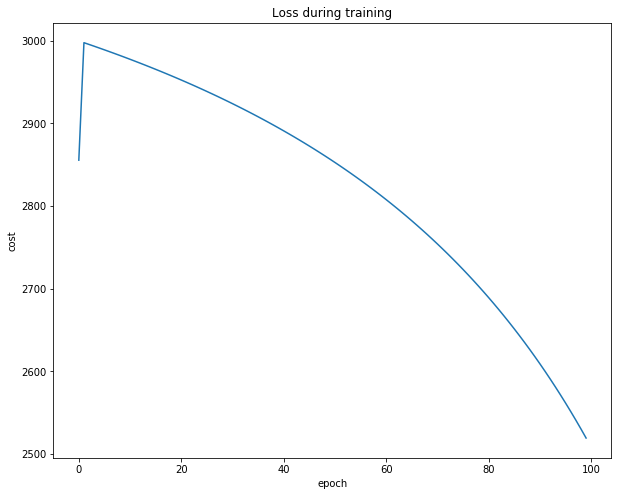

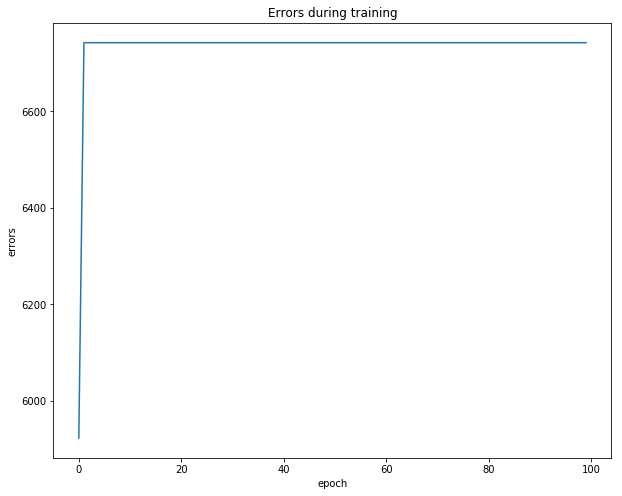

In [14]:
adaQL.learn(X_train, Y_train, eta=0.01, epochs=100)
adaQL.plot_train_loss()
adaQL.plot_train_errors()

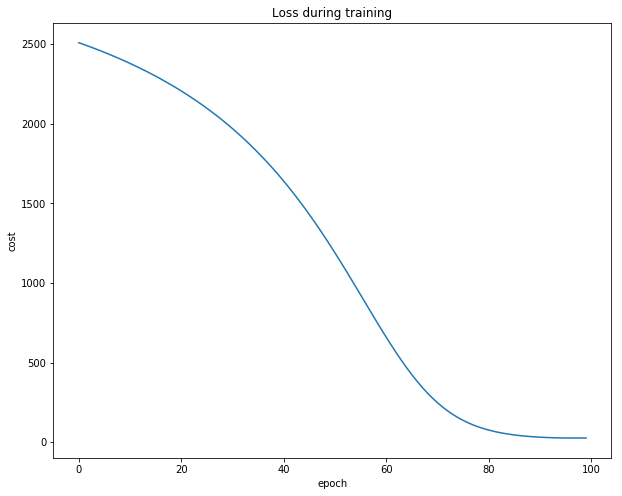

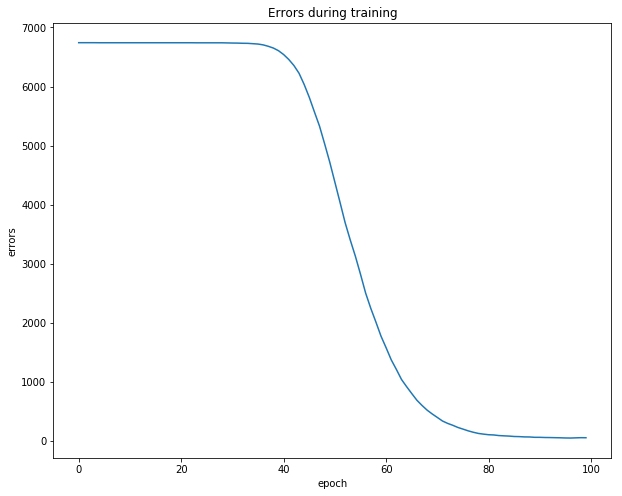

In [15]:
adaQL.learn(X_train, Y_train, eta=0.01, epochs=100)
adaQL.plot_train_loss()
adaQL.plot_train_errors()

In [16]:
X_all = np.concatenate((X_train, X_test))
Y_all = np.concatenate((Y_train, Y_test))

eff_train = adaQL.efficiency(X_train, Y_train)
eff_test = adaQL.efficiency(X_test, Y_test)
eff_all = adaQL.efficiency(X_all, Y_all)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

Efficiency (train) = 0.9954204500592183
Efficiency (test)  = 0.9976359338061466
Efficiency (all)   = 0.9957374830852503


In [17]:
# Adaline for logistic activation and cross-entropy loss function

class AdalineCrossEntropy:

    def __init__(self, num):
        '''
        initialize class for `num` input signals
        '''

        # weights of the Adaline, initialized to zero
        # note the '1 + ' as the first weight entry is the threshold
        self.w_ = 0.025*np.ones(1 + num)

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        # compute alpha(w*x)
        input = 1/(1+np.exp(-np.dot(X, self.w_[1:]) + self.w_[0]))

        return input
        # return np.dot(X, self.w_[1:]) + self.w_[0]

    def classify(self, X):
        '''
        classify the data by sending the activation input through a step function
        '''
        return np.where(self.activation_input(X) >= 0.5, 1, 0)
    
    def learn(self, X_train, Y_train, eta=0.01, epochs=1000):
        '''
        fit training data according to eta and n_iter
        and log the errors in errors_
        '''

        # we initialize two list, each for the misclassifications and the cost function
        self.train_errors_ = []
        self.train_loss_ = []

        # for all the epoch
        for _ in range(epochs):
            # classify the traning features
            Z = self.classify(X_train)
            # count the misqualifications for the logging
            err = 0
            for z, y in zip(Z, Y_train):
                err += int(z != y)
            # ans save them in the list for later use
            self.train_errors_.append(err)
            
            # compute the activation input of the entire training features
            output = self.activation_input(X_train)
            # and then the deviation from the labels
            delta = Y_train - output
            # derivative of activation
            #deriv = output/(1 - output)
            # the following is an implementation of the adaline update rule
            # with cross-entropy
            self.w_[1:] += eta * np.dot(X_train.T, delta)/len(delta)
            self.w_[0] += eta * delta.sum()/len(delta)
            loss = -1 * (Y_train*np.log(output) + (1 - Y_train)*np.log(1 - output)).sum()

            # save loss function it for later use
            self.train_loss_.append(loss)

        return
    
    def plot_train_loss(self):
        '''
        plots the loss function value per epoch
        '''

        # create two lists, one enumerating the epochs, the other the cost values
        epochs, num_errs = np.arange(len(self.train_loss_)), np.array(self.train_loss_)

        # plot the loss per epoch
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('cost')
        axs.set_title('Loss during training')
        plt.plot(epochs, num_errs)

        return
        
    def plot_train_errors(self):
        '''
        plot the number of misclassifications per epoch
        '''

        # create two list, one with epoch numbers, and one with the errors per epoch
        epochs, num_errs = np.arange(len(self.train_errors_)), np.array(self.train_errors_)

        # plot the above data
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('errors')
        axs.set_title('Errors during training')
        plt.plot(epochs, num_errs)

        return

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

In [18]:
adaCE = AdalineCrossEntropy(X_train.shape[1])

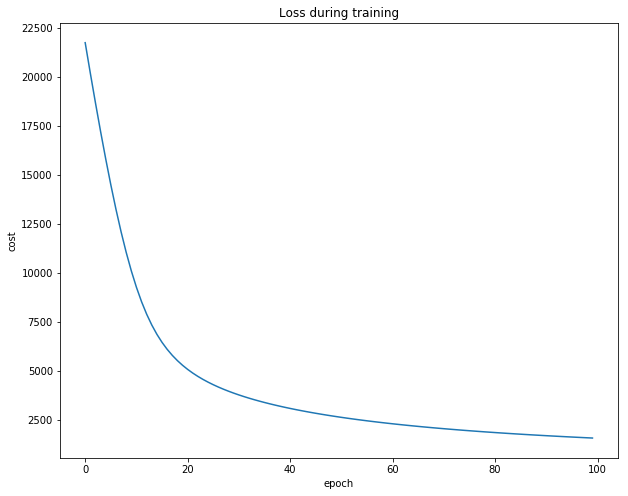

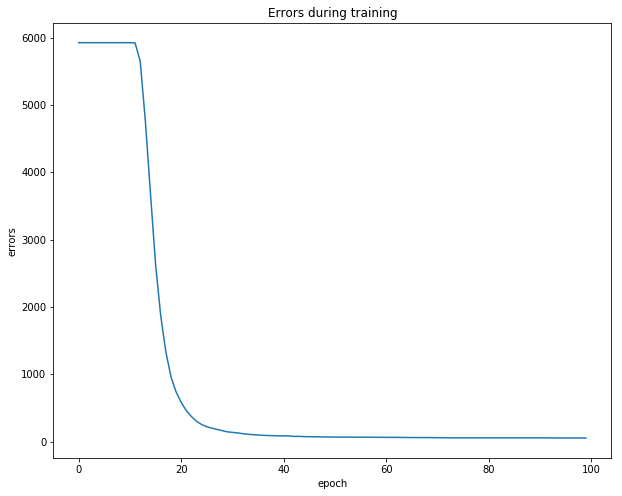

In [19]:
adaCE.learn(X_train, Y_train, eta=0.01, epochs=100)
adaCE.plot_train_loss()
adaCE.plot_train_errors()

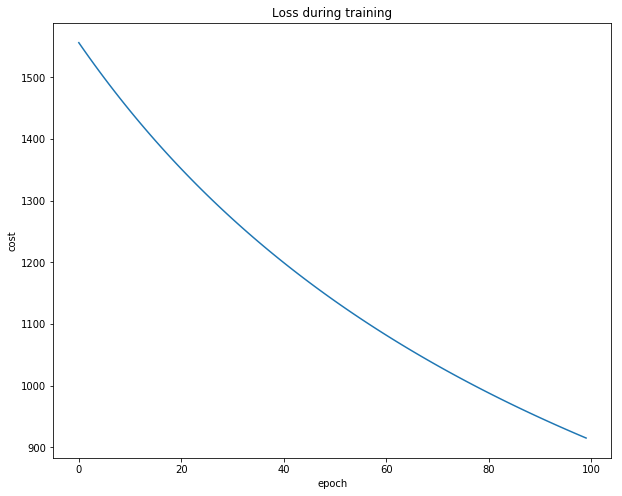

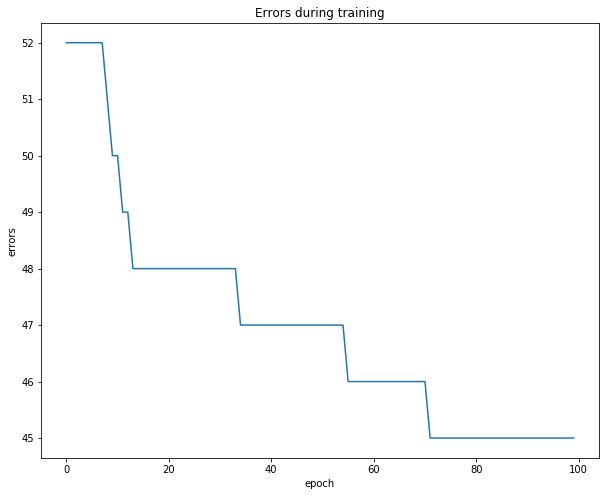

In [20]:
adaCE.learn(X_train, Y_train, eta=0.01, epochs=100)
adaCE.plot_train_loss()
adaCE.plot_train_errors()

In [21]:
X_all = np.concatenate((X_train, X_test))
Y_all = np.concatenate((Y_train, Y_test))

eff_train = adaCE.efficiency(X_train, Y_train)
eff_test = adaCE.efficiency(X_test, Y_test)
eff_all = adaCE.efficiency(X_all, Y_all)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

Efficiency (train) = 0.9964469009080142
Efficiency (test)  = 0.9985815602836879
Efficiency (all)   = 0.9967523680649526
